In [22]:
import torch.nn

In [23]:
from sklearn.datasets import make_circles
N_samples=1000
x,y= make_circles(n_samples=N_samples,noise=0.03,random_state=42)

In [24]:
## view shapes to know the number of inputs for our ANN
print(x.shape)
print(y.shape)


(1000, 2)
(1000,)


In [25]:
# make them into dataframe
import pandas as pd
circles = pd.DataFrame({"X1": x[:, 0],
    "X2": x[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [26]:
import torch
# now we will convert data into tensors
x= torch.from_numpy(x).type(torch.float)
y=torch.from_numpy(y).type(torch.float)
# Now checking their type
print(type(x))


<class 'torch.Tensor'>


In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(x,y,test_size=0.2,random_state=42)

In [45]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [46]:
## building model class
class model1(nn.Module):
  def __init__(self):
    # here we created three layers for training and used and the
    super().__init__()
    self.layer_1= nn.Linear(in_features=2,out_features=256)
    self.layer_2= nn.Linear(in_features=256,out_features=128)
    self.layer_3= nn.Linear(in_features=128,out_features=1)
    self.relu=nn.ReLU()


  def forward(self,x):
    # here is the operation that our model should do
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [38]:
MODEL_1= model1().to(device)
MODEL_1

model1(
  (layer_1): Linear(in_features=2, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [39]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=1),
   ## nn.Sigmoid()

).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=1, bias=True)
)

In [51]:
#define loss fucntion
loss= nn.BCEWithLogitsLoss()
optimizer= torch.optim.Adam(params=MODEL_1.parameters(),lr=0.001)

In [52]:
## TRAINING LOOP
torch.manual_seed(42)
epochs=1000
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
for epoch in range(epochs):
  y_logits=MODEL_1(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))
  ## calculate the loss here
  train_loss=loss(y_logits,y_train) # Renamed loss variable
  # set prev gardient to zero
  ## the gradients here are the dx/dy of the loss function
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  ## testing
  MODEL_1.eval()
  with torch.inference_mode():
    test_logits=MODEL_1(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))
    test_loss_value=loss(test_logits,y_test) # Renamed loss variable
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f},  Test Loss: {test_loss_value:.5f}")

Epoch: 0 | Loss: 0.69720,  Test Loss: 0.69118
Epoch: 100 | Loss: 0.04176,  Test Loss: 0.06471
Epoch: 200 | Loss: 0.00841,  Test Loss: 0.02076
Epoch: 300 | Loss: 0.00396,  Test Loss: 0.01285
Epoch: 400 | Loss: 0.00236,  Test Loss: 0.00941
Epoch: 500 | Loss: 0.00159,  Test Loss: 0.00755
Epoch: 600 | Loss: 0.00115,  Test Loss: 0.00632
Epoch: 700 | Loss: 0.00088,  Test Loss: 0.00544
Epoch: 800 | Loss: 0.00069,  Test Loss: 0.00479
Epoch: 900 | Loss: 0.00055,  Test Loss: 0.00427


In [54]:
## model test
MODEL_1.eval()
with torch.inference_mode():
  y_logits=MODEL_1(X_test).squeeze()
  the_loss=loss(y_logits,y_test)
  y_pred=torch.round(torch.sigmoid(y_logits))
y_pred[:10] , y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

In [57]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(model, X, y):
    # Move X and y to CPU if they are on GPU
    X = X.cpu().numpy() if X.is_cuda else X.numpy()
    y = y.cpu().numpy() if y.is_cuda else y.numpy()

    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.01

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict the function value for the whole grid
    grid = np.c_[xx.ravel(), yy.ravel()]
    with torch.no_grad():
        # Ensure the grid input to the model is a float tensor and on the correct device
        Z = model(torch.from_numpy(grid).float().to(device)).cpu().numpy()
    Z = (Z > 0.5).astype(int)  # convert probability to class

    Z = Z.reshape(xx.shape)

    # Plot contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, edgecolor='k')
    plt.show()

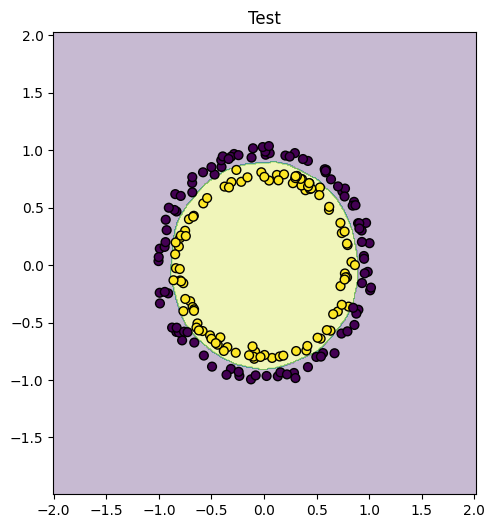

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.title("Test")
plot_decision_boundary(MODEL_1, X_test, y_test) # model_3 = has non-linearity